#### Import dependencies

In [1]:
import findspark
findspark.init()
import pyspark

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

#### Load data

In [3]:
# path of the current directory
cur_dir = os.getcwd()
print("Current directory: {}".format(cur_dir))

data_path = cur_dir+"/drugsCom"
train_path = data_path + "/train.csv"
test_path = data_path + "/test.csv"
whole_path = data_path + "/whole.csv"
fda_path = data_path + "/fda.csv"

print("Path of the raw data: {}".format(data_path))
print("Files in the drugCom directory: {}".format(os.listdir(data_path)))

Current directory: /Users/qin/Desktop/DrugCom/CS6250_Project
Path of the raw data: /Users/qin/Desktop/DrugCom/CS6250_Project/drugsCom
Files in the drugCom directory: ['whole.csv', 'test.csv', 'drugs_recalls_fda.tsv', 'readme.md', 'drugsComTest_raw.tsv', 'fda.csv', 'whole_num.csv', 'drugsComTrain_raw.tsv', 'train.csv']


#### drugs.com data

In [4]:
#train = pd.read_csv(train_path)
#test = pd.read_csv(test_path)
whole_pd = pd.read_csv(whole_path)
whole_pd.head()

,id,drugName,condition,review,rating,date,usefulCount,partial_name,is_recalled,review_length,review_word_count,cleaned_words,review_cleaned_word_count,review_avg_word_length,review_avg_cleaned_word_length
0,206461,Valsartan,left ventricular dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27,valsartan,True,79,17,"['side', 'effect', 'take', 'combination', 'bys...",8,3.705882,5.250000
1,95260,Guanfacine,adhd,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192,guanfacine,False,741,141,"['son', 'halfway', 'fourth', 'week', 'intuniv'...",65,4.262411,5.630769
2,92703,Lybrel,birth control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17,lybrel,False,755,133,"['used', 'take', 'another', 'oral', 'contracep...",69,4.684211,5.637681
3,138000,Ortho Evra,birth control,"""This is my first time using any form of birth...",8.0,2015-11-03,10,ortho evra,False,448,89,"['first', 'time', 'using', 'form', 'birth', 'c...",39,4.044944,5.282051
4,35696,Buprenorphine / naloxone,opiate dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37,buprenorphine,False,719,134,"['suboxone', 'completely', 'turned', 'life', '...",59,4.373134,6.355932


In [5]:
# fill na first (some data in the condition is missing)
print(whole_pd.isna().any())
whole_pd['condition'] = whole_pd['condition'].fillna('')

id                                False
drugName                          False
condition                          True
review                            False
rating                            False
date                              False
usefulCount                       False
partial_name                      False
is_recalled                       False
review_length                     False
review_word_count                 False
cleaned_words                     False
review_cleaned_word_count         False
review_avg_word_length            False
review_avg_cleaned_word_length    False
dtype: bool


In [6]:
type(whole_pd['date'][0])

str

In [7]:
whole_pd['date'] = pd.to_datetime(whole_pd['date'])

In [8]:
type(whole_pd['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [9]:
whole_pd['is_recalled'] = whole_pd['is_recalled'].apply(lambda x: x * 1)

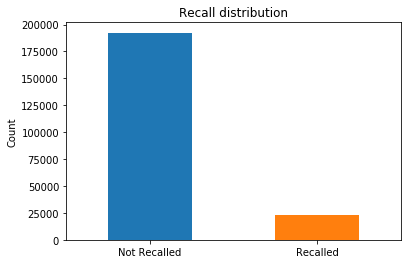

In [10]:
count_classes = pd.value_counts(whole_pd['is_recalled'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
LABELS = ["Not Recalled", "Recalled"]
plt.title("Recall distribution")
plt.xticks(range(2), LABELS)
plt.ylabel("Count");

In [11]:
is_recalled = whole_pd[whole_pd['is_recalled'] == 1]
not_recalled = whole_pd[whole_pd['is_recalled'] == 0]

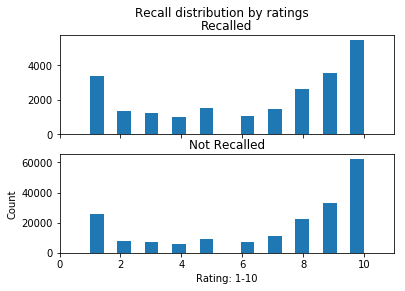

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Recall distribution by ratings')

bins = 20

ax1.hist(is_recalled['rating'], bins = bins)
ax1.set_title('Recalled')

ax2.hist(not_recalled['rating'], bins = bins)
ax2.set_title('Not Recalled')

plt.xlabel('Rating: 1-10')
plt.ylabel('Count')

plt.xlim((0, 11))
plt.show();


In [13]:
#is_recalled.loc[:, 'date_m'] = is_recalled.loc[:, 'date'].dt.to_period('M')
#not_recalled.loc[:, 'date_m'] = not_recalled.loc[:, 'date'].dt.to_period('M')

In [14]:
is_recalled['year'] = is_recalled['date'].apply(lambda x: x.year)
not_recalled['year'] = not_recalled['date'].apply(lambda x: x.year)

/Users/qin/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/qin/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
def positive_negative(rating):
    if rating > 7:
        return 1
    if rating < 4:
        return -1
    else:
        return 0

In [16]:
is_recalled['review_level'] = is_recalled['rating'].apply(positive_negative)
not_recalled['review_level'] = not_recalled['rating'].apply(positive_negative)

/Users/qin/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/qin/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


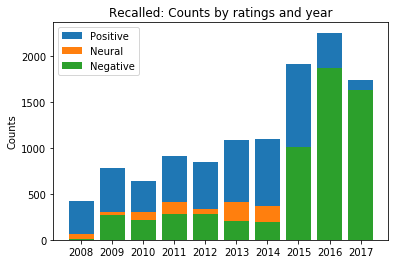

In [17]:
tmp = is_recalled.groupby(by = ['year', 'review_level']).size().reset_index().rename(columns = {0:'count'})
tmp['review_level'] = tmp['review_level'].apply(int)
N = tmp.iloc[:, 0].nunique()
rating_1 = tmp[tmp['review_level']==1]['count']
rating_2 = tmp[tmp['review_level']==0]['count']
rating_3 = tmp[tmp['review_level']==-1]['count']

ind = np.arange(N)    # the x locations for the groups

p1 = plt.bar(ind, rating_1)
p2 = plt.bar(ind, rating_2)
p3 = plt.bar(ind, rating_3)


plt.ylabel('Counts')
plt.title('Recalled: Counts by ratings and year')
plt.xticks(ind, tuple(str(x) for x in range(2008, 2018)))
plt.legend((p1[0], p2[0], p3[0]), ('Positive', 'Neural', 'Negative'))

plt.show()

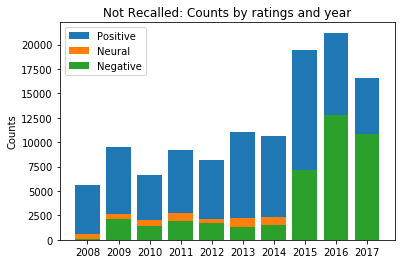

In [18]:
tmp = not_recalled.groupby(by = ['year', 'review_level']).size().reset_index().rename(columns = {0:'count'})
tmp['review_level'] = tmp['review_level'].apply(int)
N = tmp.iloc[:, 0].nunique()
rating_1 = tmp[tmp['review_level']==1]['count']
rating_2 = tmp[tmp['review_level']==0]['count']
rating_3 = tmp[tmp['review_level']==-1]['count']

ind = np.arange(N)    # the x locations for the groups

p1 = plt.bar(ind, rating_1)
p2 = plt.bar(ind, rating_2)
p3 = plt.bar(ind, rating_3)


plt.ylabel('Counts')
plt.title('Not Recalled: Counts by ratings and year')
plt.xticks(ind, tuple(str(x) for x in range(2008, 2018)))
plt.legend((p1[0], p2[0], p3[0]), ('Positive', 'Neural', 'Negative'))

plt.show()

In [19]:
# Only use some of the numerical variables
whole_num_pd = whole_pd.loc[:, ['rating', 'usefulCount', 'review_length', 'review_word_count', 'review_cleaned_word_count', 'review_avg_word_length', 'review_avg_cleaned_word_length', 'is_recalled']]
whole_num_pd.head()

,rating,usefulCount,review_length,review_word_count,review_cleaned_word_count,review_avg_word_length,review_avg_cleaned_word_length,is_recalled
0,9.0,27,79,17,8,3.705882,5.250000,1
1,8.0,192,741,141,65,4.262411,5.630769,0
2,5.0,17,755,133,69,4.684211,5.637681,0
3,8.0,10,448,89,39,4.044944,5.282051,0
4,9.0,37,719,134,59,4.373134,6.355932,0


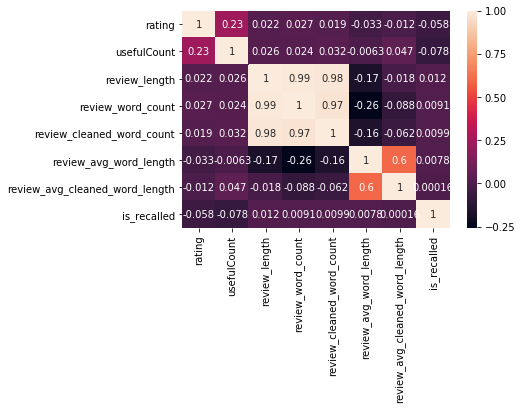

In [20]:
import seaborn as sns

Var_Corr = whole_num_pd.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

In [21]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession
sc = pyspark.SparkContext(appName="drugsCom")
# Create my_spark
spark = SparkSession.builder.getOrCreate()
# Print the tables in the catalog
print(spark.catalog.listTables())

[]


In [22]:
# convert pd.dataframe into spark.dataframe
whole_spark = spark.createDataFrame(whole_pd)
#whole = spark.read.csv(whole_path, header = True)
whole_spark.show()

+------+--------------------+--------------------+--------------------+------+-------------------+-----------+-----------------+-----------+-------------+-----------------+--------------------+-------------------------+----------------------+------------------------------+
|    id|            drugName|           condition|              review|rating|               date|usefulCount|     partial_name|is_recalled|review_length|review_word_count|       cleaned_words|review_cleaned_word_count|review_avg_word_length|review_avg_cleaned_word_length|
+------+--------------------+--------------------+--------------------+------+-------------------+-----------+-----------------+-----------+-------------+-----------------+--------------------+-------------------------+----------------------+------------------------------+
|206461|           Valsartan|left ventricular ...|"It has no side e...|   9.0|2012-05-20 00:00:00|         27|        valsartan|          1|           79|               17|['side

In [23]:
print(type(whole_spark))
whole_spark.createOrReplaceTempView("whole")
print(spark.catalog.listTables())

<class 'pyspark.sql.dataframe.DataFrame'>
[Table(name='whole', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


In [24]:
whole_spark.select('review').show()

+--------------------+
|              review|
+--------------------+
|"It has no side e...|
|"My son is halfwa...|
|"I used to take a...|
|"This is my first...|
|"Suboxone has com...|
|"2nd day on 5mg s...|
|"He pulled out, b...|
|"Abilify changed ...|
|" I Ve had  nothi...|
|"I had been on th...|
|"I have been on t...|
|"I have taken ant...|
|"I had Crohn&#039...|
|"Have a little bi...|
|"Started Nexplano...|
|"I have been taki...|
|"This drug worked...|
|"I&#039;ve been t...|
|"I&#039;ve been o...|
|"I have been on T...|
+--------------------+
only showing top 20 rows



In [25]:
whole_spark.groupBy().avg('rating', 'usefulCount', 'review_length', 'review_word_count', 'review_avg_word_length', 'review_avg_cleaned_word_length').collect()

[Row(avg(rating)=6.990007579174474, avg(usefulCount)=28.00100435686287, avg(review_length)=458.62074833885885, avg(review_word_count)=85.632028754365, avg(review_avg_word_length)=4.44472612218972, avg(review_avg_cleaned_word_length)=5.7409047694862805)]

In [26]:
# Analysis on numerical variables
whole_num_spark = whole_spark.select('rating', 'usefulCount', 'review_length', 'review_word_count', 'review_cleaned_word_count', 'review_avg_word_length', 'review_avg_cleaned_word_length', 'is_recalled')

In [27]:
# Glance at whole_num
whole_num_spark.take(2)

[Row(rating=9.0, usefulCount=27, review_length=79, review_word_count=17, review_cleaned_word_count=8, review_avg_word_length=3.7058823529411766, review_avg_cleaned_word_length=5.25, is_recalled=1),
 Row(rating=8.0, usefulCount=192, review_length=741, review_word_count=141, review_cleaned_word_count=65, review_avg_word_length=4.26241134751773, review_avg_cleaned_word_length=5.630769230769231, is_recalled=0)]

In [28]:
type(whole_num_spark)

pyspark.sql.dataframe.DataFrame

In [29]:
whole_num_spark.columns

['rating',
 'usefulCount',
 'review_length',
 'review_word_count',
 'review_cleaned_word_count',
 'review_avg_word_length',
 'review_avg_cleaned_word_length',
 'is_recalled']

In [30]:
from pyspark.ml.feature import VectorAssembler
cols = whole_num_spark.columns
vectorAss = VectorAssembler(inputCols=cols, outputCol="features")
vdf = vectorAss.transform(whole_num_spark)


In [31]:
type(vdf)

pyspark.sql.dataframe.DataFrame

In [32]:
vdf.take(1)

[Row(rating=9.0, usefulCount=27, review_length=79, review_word_count=17, review_cleaned_word_count=8, review_avg_word_length=3.7058823529411766, review_avg_cleaned_word_length=5.25, is_recalled=1, features=DenseVector([9.0, 27.0, 79.0, 17.0, 8.0, 3.7059, 5.25, 1.0]))]

In [33]:
whole_num_spark.describe().show()

+-------+------------------+-----------------+------------------+-----------------+-------------------------+----------------------+------------------------------+-------------------+
|summary|            rating|      usefulCount|     review_length|review_word_count|review_cleaned_word_count|review_avg_word_length|review_avg_cleaned_word_length|        is_recalled|
+-------+------------------+-----------------+------------------+-----------------+-------------------------+----------------------+------------------------------+-------------------+
|  count|            215063|           215063|            215063|           215063|                   215063|                215063|                        215063|             215063|
|   mean| 6.990007579174474|28.00100435686287|458.62074833885885|  85.632028754365|        40.14616182234973|      4.44472612218972|            5.7409047694862805|0.10551791800542167|
| stddev|3.2755544975903352|36.34606888350826|240.99522613005777|45.323405410588

In [34]:
whole_num_spark.columns

['rating',
 'usefulCount',
 'review_length',
 'review_word_count',
 'review_cleaned_word_count',
 'review_avg_word_length',
 'review_avg_cleaned_word_length',
 'is_recalled']

In [35]:
whole_num_spark.stat.corr('rating', 'usefulCount')

0.23485955163330302